In [1]:
#Importing libraries
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix
from sklearn import preprocessing

#tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10

# Load the DataFrame
path = "images/train"
data = {"imgpath": [], "labels": []}
category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
df = pd.DataFrame(data)

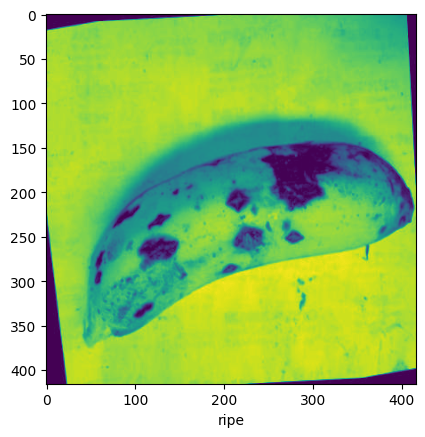

In [3]:
filepath = "images/train/ripe"

for img_path in os.listdir(filepath):
    img = cv2.imread(os.path.join(filepath, img_path), 0)
    plt.imshow(img)
    plt.xlabel(filepath.split("/")[-1])
    plt.show()   
    break

In [4]:
# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, train_size=0.70, shuffle=True, random_state=124)
valid_df, test_df = train_test_split(temp_df, train_size=0.70, shuffle=True, random_state=124)

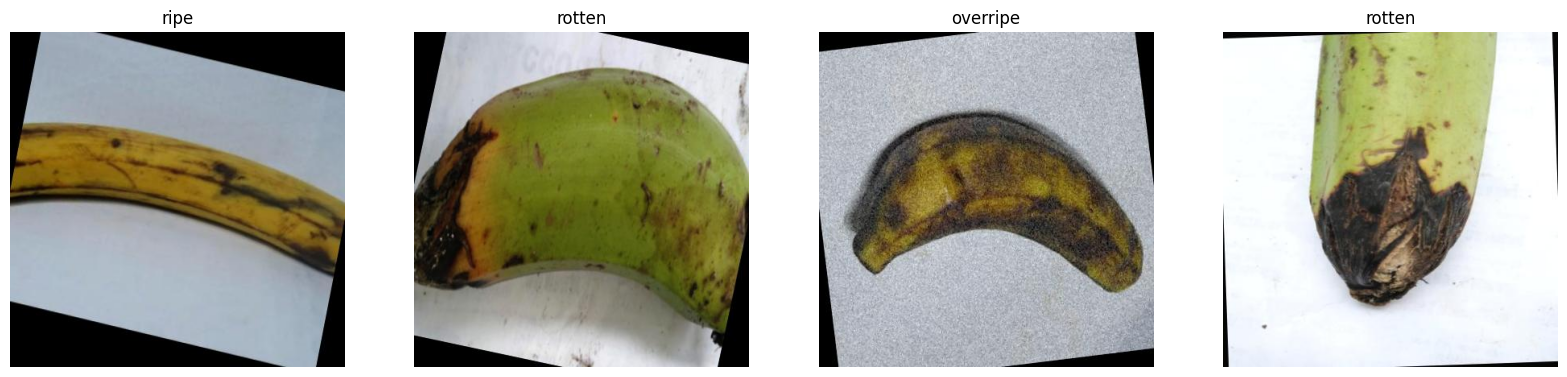

In [5]:
#Defining size of displayed image
plt.figure(figsize=(20,20))

#Displaying images from test dataframe
for i, row in test_df.sample(n=4).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["labels"])
valid_labels = label_encoder.transform(valid_df["labels"])
test_labels = label_encoder.transform(test_df["labels"])

In [7]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded vectors
num_classes = len(set(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define function to load and preprocess images
def load_images(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load and preprocess train, validation, and test images
train_images = load_images(train_df["imgpath"])
valid_images = load_images(valid_df["imgpath"])
test_images = load_images(test_df["imgpath"])

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define custom callback to stop training once the accuracy reaches 0.9
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        print(f"Validation Accuracy at epoch {epoch + 1}: {val_accuracy}")
        if val_accuracy >= 0.9:
            print("\nReached 90% accuracy! Stopping training...")
            self.model.stop_training = True

# Load the pre-trained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the convolutional base
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(num_classes, activation="softmax")
])

In [10]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
# Train the model with the custom callback
history = model.fit(
    x=train_images, y=train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    callbacks=[MyCallback()]
)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4974 - loss: 2.3636Validation Accuracy at epoch 1: 0.8478803038597107
84/84 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.4994 - loss: 2.3501 - val_accuracy: 0.8479 - val_loss: 0.3682
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9249 - loss: 0.2226Validation Accuracy at epoch 2: 0.8678303956985474
84/84 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.9249 - loss: 0.2223 - val_accuracy: 0.8678 - val_loss: 0.3423
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9689 - loss: 0.1074Validation Accuracy at epoch 3: 0.9476309418678284

Reached 90% accuracy! Stopping training...
84/84 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.9690 - loss: 0.1072 - val_accuracy: 0.9476 - val_loss: 0.1644


In [13]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.9683 - loss: 0.1088
Test Loss: 0.11543604731559753
Test Accuracy: 0.9709302186965942


In [14]:
# Save the model
model.save("banana_classification.h5")

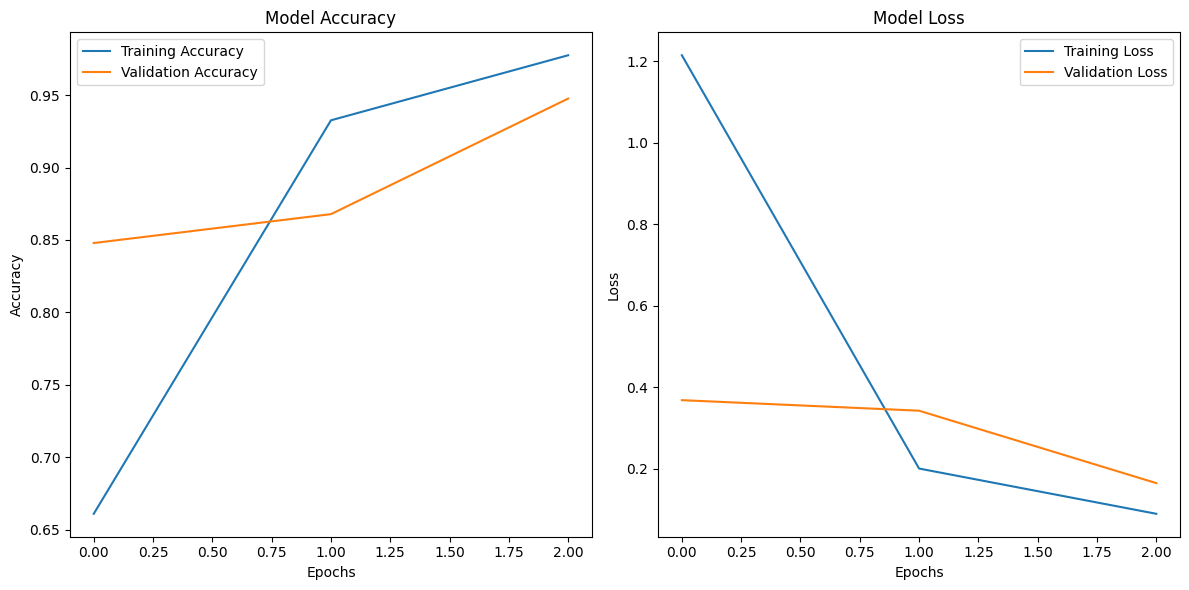

In [15]:
# Import necessary libraries
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Generate predictions for the test set
y_pred = model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

6/6 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step
Classification Report:

              precision    recall  f1-score   support

    overripe       0.90      1.00      0.95        27
        ripe       0.98      0.93      0.96        46
      rotten       1.00      0.98      0.99        60
      unripe       0.97      0.97      0.97        39

    accuracy                           0.97       172
   macro avg       0.96      0.97      0.97       172
weighted avg       0.97      0.97      0.97       172



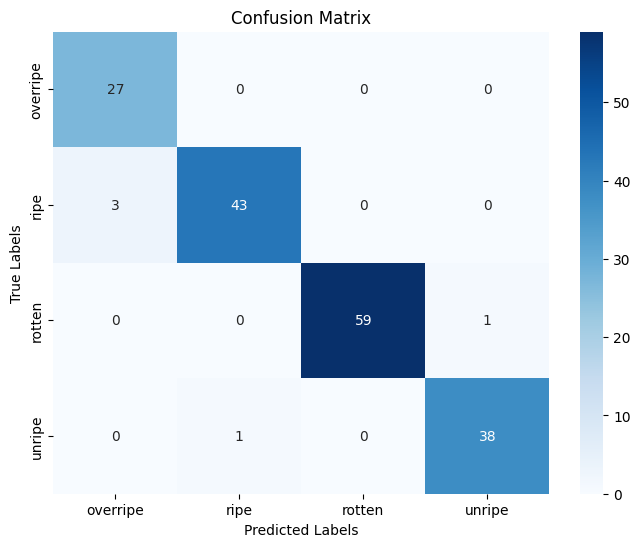

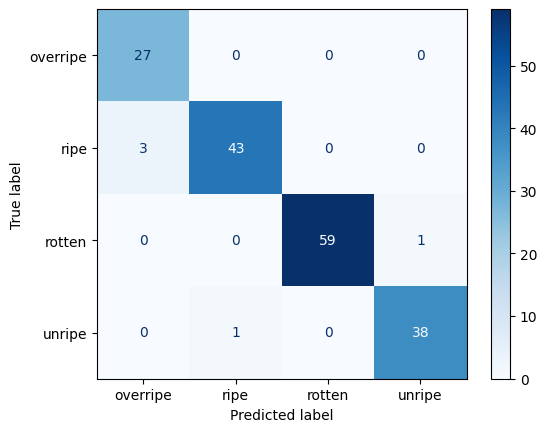

In [18]:
# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Confusion matrix display using sklearn
ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes, display_labels=label_encoder.classes_, cmap='Blues')
plt.show()

In [19]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf

# Define your class labels
class_labels = ["overripe", "ripe", "rotten", "unripe"]

# Function to preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize pixel values
    return image

# Function to predict class
def predict_image(image_path, model):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    return predicted_class, confidence

# Example: Check another image and get prediction
image_path = "images/train/unripe/musa-acuminata-freshunripe-260083fb-2653-11ec-b741-d8c4975e38aa---Copy_jpg.rf.d6bccc54f419ae35e050b91b4ec4e59e.jpg"  # Replace with the path to your image
predicted_class, confidence = predict_image(image_path, model)
predicted_class_name = class_labels[predicted_class]
print("Predicted class:", predicted_class_name)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
Predicted class: unripe
Confidence: 0.9990398
